<h1><center>ORF 311 Final Project</center></h1>
<h3><center>By: Austin Stiefelmaier</center></h3>

In [1]:
# Imports
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Dataset imports
assets = pd.read_excel('Assets_and_Factors.xlsx', sheet_name = 'Assets', usecols = 'B:E')
factors = pd.read_excel('Assets_and_Factors.xlsx', sheet_name = 'Factors', usecols = 'B:F')

# Add intercept column as last column
factors['Intercept'] = pd.Series(np.ones(len(factors.index)), index=factors.index)

# Separate assets
USEquities = assets[['US Equities']]
RealEstate = assets[['Real Estate']]
Commodities = assets[['Commodities']]
CorpBonds = assets[['Corp Bonds']]

# Convert to numpy arrays
factors = factors.values
USEquities = USEquities.values
RealEstate = RealEstate.values
Commodities = Commodities.values
CorpBonds = CorpBonds.values

**Part 1:**

In [8]:
# Generate risk profile for each asset
volUSE = np.std(USEquities)
varUSE = np.percentile(USEquities, 5)
volRE = np.std(RealEstate)
varRE = np.percentile(RealEstate, 5)
volCom = np.std(Commodities)
varCom = np.percentile(Commodities, 5)
volCB = np.std(CorpBonds)
varCB = np.percentile(CorpBonds, 5)

print("Volatility of US Equities: " + str(volUSE))
print("VaR (5%) of US Equities: " + str(varUSE))
print("Volatility of Real Estate: " + str(volRE))
print("VaR (5%) of Real Estate: " + str(varRE))
print("Volatility of Commodities: " + str(volCom))
print("VaR (5%) of Commodities: " + str(varCom))
print("Volatility of Corp Bonds: " + str(volCB))
print("VaR (5%) of Corp Bonds: " + str(varCB))

Volatility of US Equities: 0.044908085367479644
VaR (5%) of US Equities: -0.0695674
Volatility of Real Estate: 0.054702551343041333
VaR (5%) of Real Estate: -0.0578484
Volatility of Commodities: 0.058694759719394
VaR (5%) of Commodities: -0.09187179999999999
Volatility of Corp Bonds: 0.018710468687153436
VaR (5%) of Corp Bonds: -0.018559399999999993


**Part 2:**

In [10]:
# Get covariance matrix, Q
Q = np.cov(np.concatenate((USEquities, RealEstate, Commodities, CorpBonds), axis = 1), rowvar = False)

In [12]:
# Get simulated values where it's a 3d array of (10000, 4, 60) where there are 10000 scenarios, 4 assets,
# and 60 periods (5 years) 
r = np.array([0.00448, 0.00171, 0.00551, 0.00393])
simVals = np.random.normal(r, Q)
for x in range(2499):
    sim = np.random.normal(r, Q)
    simVals = np.concatenate((simVals, sim), axis = 0)
totalSimVals = simVals
for x in range(59):
    simVals = np.random.normal(r, Q)
    for x in range(2499):
        sim = np.random.normal(r, Q)
        simVals = np.concatenate((simVals, sim), axis = 0)
    totalSimVals = np.dstack((totalSimVals, simVals))
totalSimVals.shape

(10000, 4, 60)

**Part 3:**

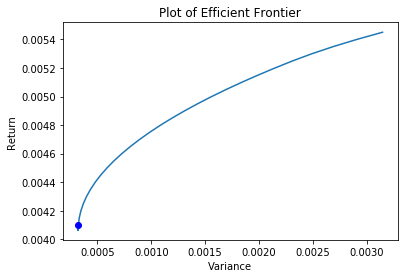

Sharpe Ratio Allocation: [5.64462132e-02 7.71074791e-08 8.79461014e-02 8.55607608e-01]


In [43]:
# Plot efficient frontier
variances = []
returns = np.arange(0.002, 0.0055, 0.00005)
actualret = []
maxSharpe = 0
sharpeAlloc = []
sharpeRet = 0
sharpeVar = 0
rfree = 0.001
for i in range(returns.size):
    w = cp.Variable((4))
    constraints = [w * r >= returns[i], cp.sum(w) == 1, w >= 0]
    obj = cp.Minimize(cp.quad_form(w, Q))
    prob = cp.Problem(obj, constraints)
    prob.solve()
    variances.append(prob.value)
    actual = np.dot(w.value, r)
    actualret.append(actual)
    sharpe = (actual - rfree) / prob.value
    if sharpe > maxSharpe:
        maxSharpe = sharpe
        sharpeAlloc = w.value
        sharpeRet = actual
        sharpeVar = prob.value
plt.plot(variances, actualret)
plt.plot(sharpeVar, sharpeRet, 'bo')
plt.xlabel('Variance');
plt.ylabel('Return');
plt.title('Plot of Efficient Frontier')
plt.show()
print('Sharpe Ratio Allocation: ' + str(sharpeAlloc))

**Part 4:**

In [67]:
# Simulate wealth path for asset allocation according to max Sharpe Ratio
weights = sharpeAlloc
capital = np.zeros((10000, 60))
for s in range(10000):
    salary = 95000
    cap = salary * 0.85 # initial wealth to invest after savings
    for t in range(60):
        if (t+1) % 12 == 0:
            salary *= 1.1 # Grow salary by 10% if in new year
            cap += salary * 0.85 # Add after savings salary to capital
        cap += np.sum(weights * cap * totalSimVals[s,::,t])
        capital[s, t] = cap
avgCap = np.mean(capital, axis = 0)

print('MAX SHARPE RATIO ALLOCATION:')
print('Mean Wealth at 3 years: ' + str(avgCap[35]))
print('Variance of Wealth at 3 years: ' + str(np.std(capital, axis = 0)[35] ** 2))
print('Value at Risk (5%) of Wealth at 3 years: ' + str(np.percentile(capital, 5, axis = 0)[35]))
print('Probability of Meeting the Goal at 3 years: ' + str((capital[:,35] > 100000).sum() / 10000.0) + '\n')

print('Mean Wealth at 3 years: ' + str(avgCap[47]))
print('Variance of Wealth at 4 years: ' + str(np.std(capital, axis = 0)[47] ** 2))
print('Value at Risk (5%) of Wealth at 4 years: ' + str(np.percentile(capital, 5, axis = 0)[47]))
print('Probability of Meeting the Goal at 4 years: ' + str((capital[:,47] > 100000).sum() / 10000.0) + '\n')

print('Mean Wealth at 5 years: ' + str(avgCap[-1]))
print('Variance of Wealth at 5 years: ' + str(np.std(capital, axis = 0)[-1] ** 2))
print('Value at Risk (5%) of Wealth at 5 years: ' + str(np.percentile(capital, 5, axis = 0)[-1]))
print('Probability of Meeting the Goal at 5 years: ' + str((capital[:,-1] > 100000).sum() / 10000.0))

MAX SHARPE RATIO ALLOCATION:
Mean Wealth at 3 years: 402924.33082674444
Variance of Wealth at 3 years: 128930.01707690168
Value at Risk (5%) of Wealth at 3 years: 402322.3050755858
Probability of Meeting the Goal at 3 years: 1.0

Mean Wealth at 3 years: 541910.2717646355
Variance of Wealth at 4 years: 314394.35268830066
Value at Risk (5%) of Wealth at 4 years: 540990.1006586661
Probability of Meeting the Goal at 4 years: 1.0

Mean Wealth at 5 years: 699769.8363324027
Variance of Wealth at 5 years: 662464.96903287
Value at Risk (5%) of Wealth at 5 years: 698422.813722092
Probability of Meeting the Goal at 5 years: 1.0


In [70]:
# Simulate wealth path for asset allocation according to 60/40 rule
weights = sharpeAlloc
weights[0] = 0.6
weights[1] = 0.0
weights[2] = 0.0
weights[3] = 0.4
capital = np.zeros((10000, 60))
for s in range(10000):
    salary = 95000
    cap = salary * 0.85 # initial wealth to invest after savings
    for t in range(60):
        if (t+1) % 12 == 0:
            salary *= 1.1 # Grow salary by 10% if in new year
            cap += salary * 0.85 # Add after savings salary to capital
        cap += np.sum(weights * cap * totalSimVals[s,::,t])
        capital[s, t] = cap
avgCap = np.mean(capital, axis = 0)

print('60/40 RULE ALLOCATION:')
print('Mean Wealth at 3 years: ' + str(avgCap[35]))
print('Variance of Wealth at 3 years: ' + str(np.std(capital, axis = 0)[35] ** 2))
print('Value at Risk (5%) of Wealth at 3 years: ' + str(np.percentile(capital, 5, axis = 0)[35]))
print('Probability of Meeting the Goal at 3 years: ' + str((capital[:,35] > 100000).sum() / 10000.0) + '\n')

print('Mean Wealth at 3 years: ' + str(avgCap[47]))
print('Variance of Wealth at 4 years: ' + str(np.std(capital, axis = 0)[47] ** 2))
print('Value at Risk (5%) of Wealth at 4 years: ' + str(np.percentile(capital, 5, axis = 0)[47]))
print('Probability of Meeting the Goal at 4 years: ' + str((capital[:,47] > 100000).sum() / 10000.0) + '\n')

print('Mean Wealth at 5 years: ' + str(avgCap[-1]))
print('Variance of Wealth at 5 years: ' + str(np.std(capital, axis = 0)[-1] ** 2))
print('Value at Risk (5%) of Wealth at 5 years: ' + str(np.percentile(capital, 5, axis = 0)[-1]))
print('Probability of Meeting the Goal at 5 years: ' + str((capital[:,-1] > 100000).sum() / 10000.0))

60/40 RULE ALLOCATION:
Mean Wealth at 3 years: 404091.18202867504
Variance of Wealth at 3 years: 1063400.0003676496
Value at Risk (5%) of Wealth at 3 years: 402327.1446511304
Probability of Meeting the Goal at 3 years: 1.0

Mean Wealth at 3 years: 543964.4796816173
Variance of Wealth at 4 years: 2569714.418565346
Value at Risk (5%) of Wealth at 4 years: 541245.3626803316
Probability of Meeting the Goal at 4 years: 1.0

Mean Wealth at 5 years: 703035.418397689
Variance of Wealth at 5 years: 5564114.603986902
Value at Risk (5%) of Wealth at 5 years: 698984.5131295949
Probability of Meeting the Goal at 5 years: 1.0


In [72]:
# Simulate wealth path for asset allocation according to my own portfolio strategy of 100% US Equities
weights = sharpeAlloc
weights[0] = 1.0
weights[1] = 0.0
weights[2] = 0.0
weights[3] = 0.0
capital = np.zeros((10000, 60))
for s in range(10000):
    salary = 95000
    cap = salary * 0.85 # initial wealth to invest after savings
    for t in range(60):
        if (t+1) % 12 == 0:
            salary *= 1.1 # Grow salary by 10% if in new year
            cap += salary * 0.85 # Add after savings salary to capital
        cap += np.sum(weights * cap * totalSimVals[s,::,t])
        capital[s, t] = cap
avgCap = np.mean(capital, axis = 0)

print('100% US Equities ALLOCATION:')
print('Mean Wealth at 3 years: ' + str(avgCap[35]))
print('Variance of Wealth at 3 years: ' + str(np.std(capital, axis = 0)[35] ** 2))
print('Value at Risk (5%) of Wealth at 3 years: ' + str(np.percentile(capital, 5, axis = 0)[35]))
print('Probability of Meeting the Goal at 3 years: ' + str((capital[:,35] > 100000).sum() / 10000.0) + '\n')

print('Mean Wealth at 3 years: ' + str(avgCap[47]))
print('Variance of Wealth at 4 years: ' + str(np.std(capital, axis = 0)[47] ** 2))
print('Value at Risk (5%) of Wealth at 4 years: ' + str(np.percentile(capital, 5, axis = 0)[47]))
print('Probability of Meeting the Goal at 4 years: ' + str((capital[:,47] > 100000).sum() / 10000.0) + '\n')

print('Mean Wealth at 5 years: ' + str(avgCap[-1]))
print('Variance of Wealth at 5 years: ' + str(np.std(capital, axis = 0)[-1] ** 2))
print('Value at Risk (5%) of Wealth at 5 years: ' + str(np.percentile(capital, 5, axis = 0)[-1]))
print('Probability of Meeting the Goal at 5 years: ' + str((capital[:,-1] > 100000).sum() / 10000.0))

100% US Equities ALLOCATION:
Mean Wealth at 3 years: 405700.33450176136
Variance of Wealth at 3 years: 2937705.312185932
Value at Risk (5%) of Wealth at 3 years: 402762.2314394501
Probability of Meeting the Goal at 3 years: 1.0

Mean Wealth at 3 years: 546807.6675385518
Variance of Wealth at 4 years: 7146268.349374148
Value at Risk (5%) of Wealth at 4 years: 542260.384946196
Probability of Meeting the Goal at 4 years: 1.0

Mean Wealth at 5 years: 707569.5710722515
Variance of Wealth at 5 years: 15544890.565721536
Value at Risk (5%) of Wealth at 5 years: 700818.4683342708
Probability of Meeting the Goal at 5 years: 1.0
